# Exercise 1: Global approach to image description

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
import cv2
from itertools import product
from pathlib import Path
import a2_utils
import math

## a) Myhist3

In [2]:
def myhist3(img, n_bins):
	H = np.zeros((n_bins, n_bins, n_bins))
	nv = 256
	for r, g, b in img.reshape((-1, 3)):
		H[(r*n_bins)//nv, (g*n_bins)//nv, (b*n_bins)//nv] += 1

	return H / np.sum(H)
	

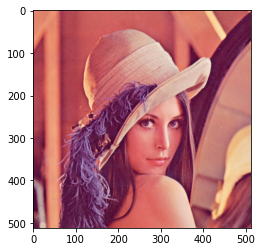

In [3]:
lena = cv2.cvtColor(cv2.imread('images/lena.png'), cv2.COLOR_BGR2RGB)
plt.imshow(lena)
lena_hist = myhist3(lena, 8)

In [4]:
def plot3dhist(ax, H, n_bins, k=4000):
	space = np.array([*product(range(n_bins), range(n_bins), range(n_bins))])
	ax.scatter(space[:,0], space[:,1], space[:,2], c=space/n_bins, s=H.flatten()*k, alpha=1)
	ax.set_xlabel('R')
	ax.set_ylabel('G')
	ax.set_zlabel('B')

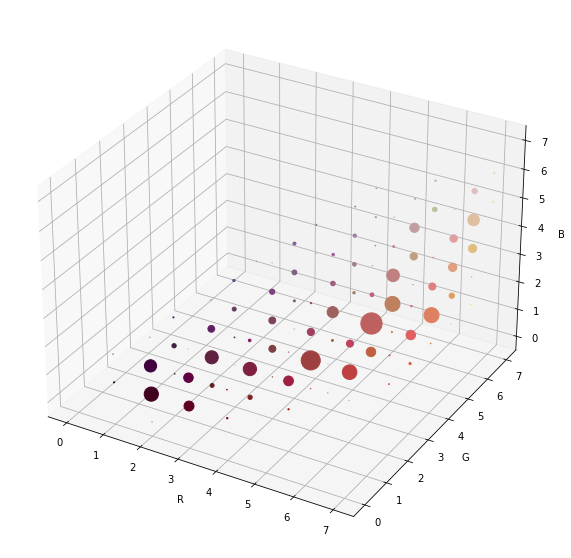

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
plot3dhist(ax, lena_hist, 8)

## b) Compare histograms

In [6]:
def compare_histograms(H1, H2, measure="L2"):
	h1, h2 = H1.flatten(), H2.flatten()
	if measure == "L2":
		return np.sqrt(np.sum((h1 - h2) ** 2))
	if measure == "chi":
		return np.sum(((h1 - h2) ** 2)/(h1 + h2 + 1e-10))/2
	if measure == "I":
		return 1-np.sum(np.minimum(h1, h2))
	if measure == "H":
		return np.sqrt(np.sum((np.sqrt(h1) - np.sqrt(h2))**2)/2)


## c) Test comparison

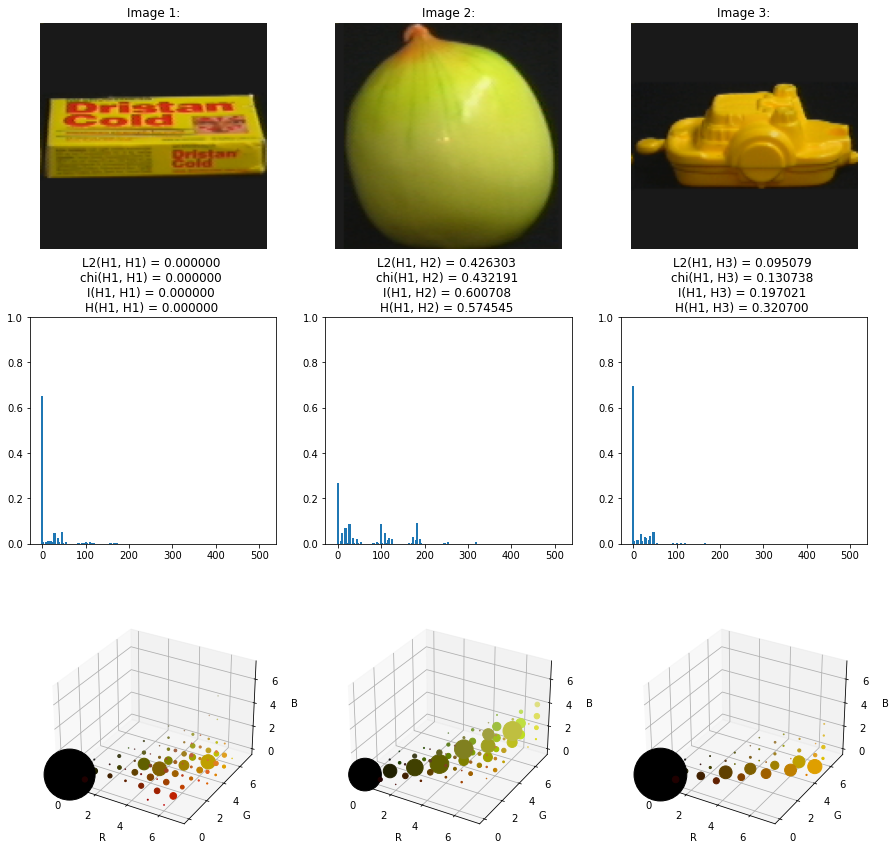

In [7]:
imgs = ['dataset/object_01_1.png', 'dataset/object_02_1.png', 'dataset/object_03_1.png']
hists = []
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace = 0.3)
n_bins = 8
for i, img_path in enumerate(imgs):
	# read image
	img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
	# display image
	ax = fig.add_subplot(3,3,i+1, title=f"Image {i+1}:")
	#plt.title(f"Image {i+1}")
	ax.imshow(img)
	ax.axis('off')
	# compute hist and distance
	hists.append(myhist3(img, n_bins))
	L2 = compare_histograms(hists[0], hists[i], measure='L2')
	chi = compare_histograms(hists[0], hists[i], measure='chi')
	I = compare_histograms(hists[0], hists[i], measure='I')
	H = compare_histograms(hists[0], hists[i], measure='H')
	# dsplay hist and distance
	ax = fig.add_subplot(3,3, 3+i+1, title=f"L2(H1, H{i+1}) = {L2:.6f} \nchi(H1, H{i+1}) = {chi:.6f} \nI(H1, H{i+1}) = {I:.6f} \nH(H1, H{i+1}) = {H:.6f} ")
	ax.set_ylim([0,1])
	ax.bar(range(n_bins**3), hists[i].transpose().flatten(), width=5)
	ax = fig.add_subplot(3,3, 6+i+1, projection="3d")
	plot3dhist(ax, hists[i], n_bins)

__*Question:*__ Which image (`object_02_1.png` or `object_03_1.png`) is more similar to image `object_01_1.png` considering the L2 distance? How about the other three distances? We can see that all three histograms contain a strongly expressed component (one bin has a much higher value than the others). Which color does this bin represent?

> In all 4 measures `object_03_1.png` is more similar to `object_01_1.png` than `object_02_1.png` is.
>
> The biggest bin of the histogram is the one containing black pixels.

## d) Simple image retrieval system

In [8]:
def calculate_histograms(path, n_bins):
	dataset = Path(path)
	Hs = []
	for img_path in dataset.iterdir():
		img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
		Hs.append((myhist3(img, n_bins), img, img_path.name))

	return Hs


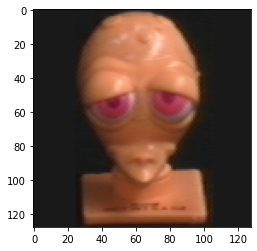

In [9]:
n_bins = 8
ref_img = cv2.cvtColor(cv2.imread('dataset/object_20_1.png'), cv2.COLOR_BGR2RGB)
ref_hist = myhist3(ref_img, n_bins)

dataset_hists = calculate_histograms('dataset', n_bins)

plt.imshow(ref_img)

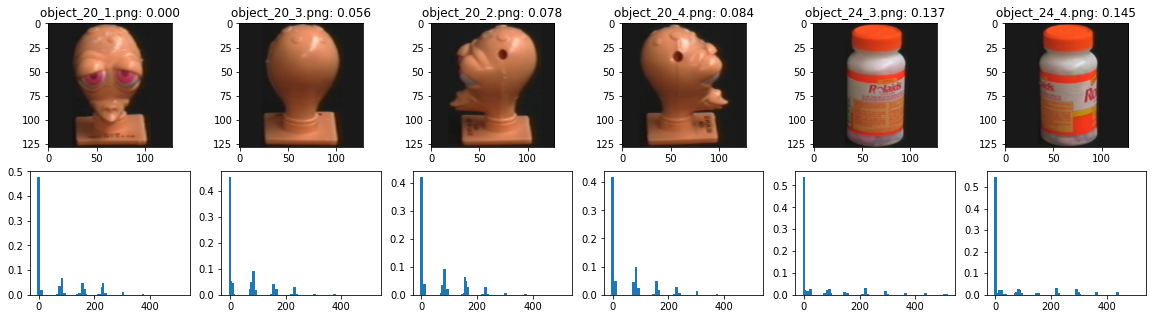

In [10]:
hists_distance = [(hist, img, name, compare_histograms(hist, ref_hist), i) for i, (hist, img, name) in enumerate(dataset_hists)]
hists_sorted = sorted(hists_distance, key=lambda a: a[3])
fig = plt.figure(figsize=(20,5))
for i, (H, img, name, distance, index) in enumerate(hists_sorted[:6]):
	ax = fig.add_subplot(2, 6, i+1, title=f"{name}: {distance:.3f}")
	ax.imshow(img)
	ax = fig.add_subplot(2, 6, 6+i+1)
	ax.bar(range(n_bins**3), H.transpose().flatten(), width=10)

## e) Distance plot

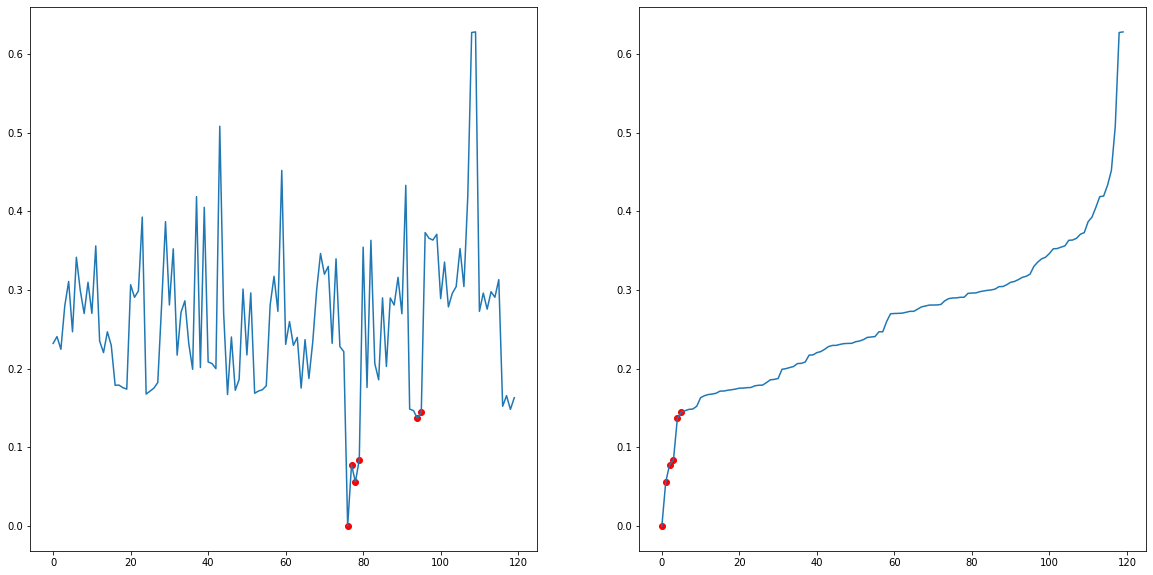

In [11]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1)
ax.plot([d[3] for d in hists_distance])
ax.scatter([i for i, h in enumerate(hists_distance) if h[4] in [h[4] for h in hists_sorted[:6]]], [h[3] for i, h in enumerate(hists_distance) if h[4] in [h[4] for h in hists_sorted[:6]]], marker="o", c='r')

ax = fig.add_subplot(1, 2, 2)
ax.plot([d[3] for d in hists_sorted])
ax.scatter(range(6), [d[3] for d in hists_sorted[:6]], marker="o", c='r')


## f) frequency-based weighting technique

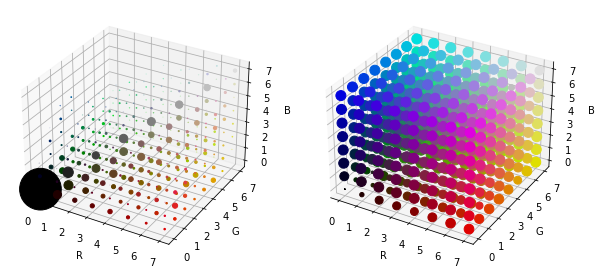

In [12]:
avg_hist = np.sum(np.array([H[0] for H in dataset_hists]), axis=0) / len(dataset_hists)
k = 100
weights = np.exp(-avg_hist*k)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1, projection="3d")
plot3dhist(ax, avg_hist, 8)
ax = fig.add_subplot(1, 2, 2, projection="3d")
plot3dhist(ax, weights, 8, k=100)

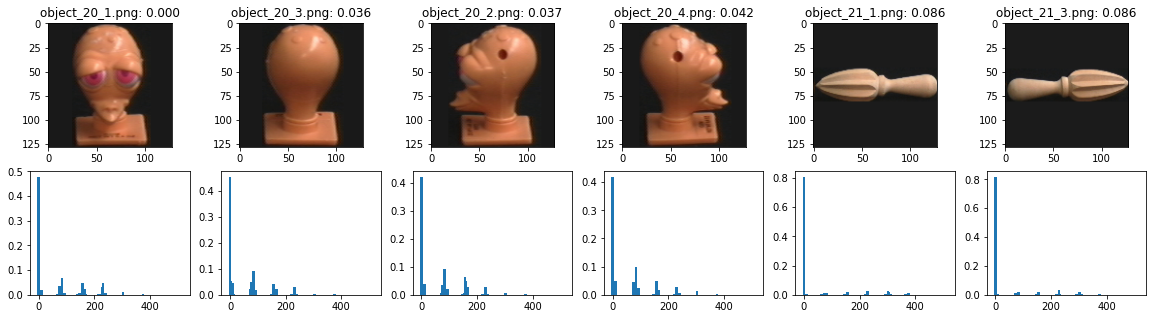

In [13]:
hists_distance = [(hist, img, name, compare_histograms(hist*weights, ref_hist*weights), i) for i, (hist, img, name) in enumerate(dataset_hists)]
hists_sorted = sorted(hists_distance, key=lambda a: a[3])

fig = plt.figure(figsize=(20,5))
for i, (H, img, name, distance, index) in enumerate(hists_sorted[:6]):
	ax = fig.add_subplot(2, 6, i+1, title=f"{name}: {distance:.3f}")
	ax.imshow(img)
	ax = fig.add_subplot(2, 6, 6+i+1)
	ax.bar(range(n_bins**3), H.transpose().flatten(), width=10)

# Exercise 2: Convolution

## a) Compute convolution by hand

<img src="konvolucija.png" width="1000px">

## b) Implement the function `simple_convolution`

In [14]:
def simple_convolution(I, k):
	N = (len(k)-1)//2

	result = []
	for i in range(N, len(I)-N):
		s = 0
		for j in range(len(k)):
			s += k[j]*I[i-j]

		result.append(s)

	return np.array(result)

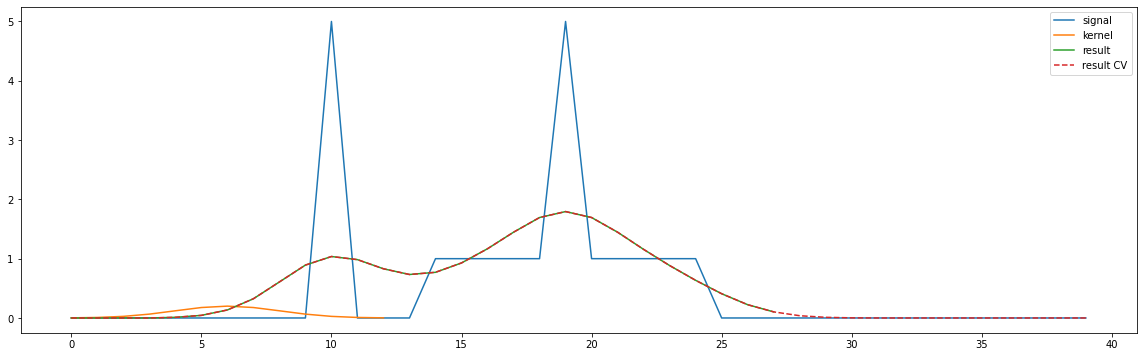

In [15]:
signal = a2_utils.read_data('signal.txt')
kernel = a2_utils.read_data('kernel.txt')

result = simple_convolution(signal, kernel)
result_cv = cv2.filter2D(signal, -1, kernel)

plt.figure(figsize=(20,6))
plt.plot(signal, label='signal')
plt.plot(kernel, label='kernel')
plt.plot(result, label='result')
plt.plot(result_cv, '--', label='result CV')
plt.legend()

In [16]:
kernel.sum()

0.9999999974

__*Question:*__ Can you recognize the shape of the kernel? What is the sum of the elements in the kernel? How does the kernel affect the signal?

> It is a Gaussian kernel. The sum of the elements in the kernel is almost 1. The kernel removes high frequency signals.

## c) Better `simple_convolution` 

In [17]:
def simple_convolution2(I, k):
	N = (len(k)-1)//2

	result = np.zeros_like(I)
	for i in range(len(I)):
		s = 0
		for j in range(len(k)):
			if i-j+N < 0 or i-j+N >= len(I): continue
			s += k[j]*I[i-j+N]

		result[i] = s

	return np.array(result)

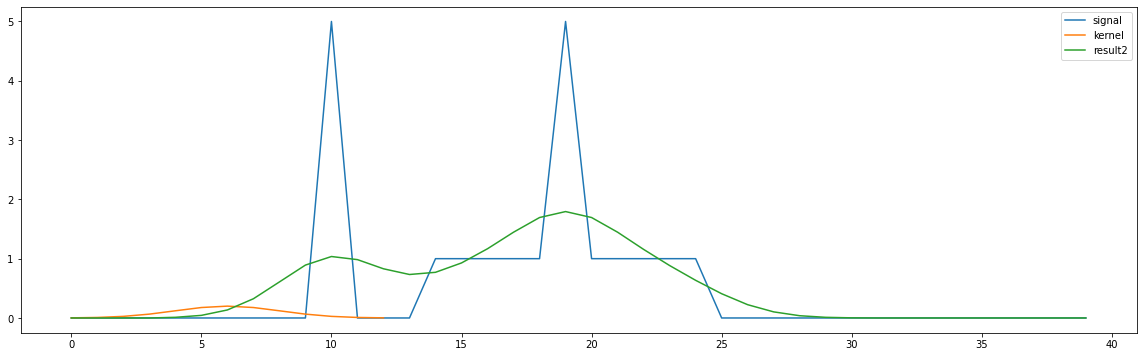

In [18]:
signal = a2_utils.read_data('signal.txt')
kernel = a2_utils.read_data('kernel.txt')

result = simple_convolution2(signal, kernel)

plt.figure(figsize=(20,6))
plt.plot(signal, label='signal')
plt.plot(kernel, label='kernel')
plt.plot(result, label='result2')
plt.legend()

## d) Write a function that calculates a Gaussian kernel
$$ g(x) = \frac{1}{\sigma\sqrt{2\pi}}\exp{\left(-\frac{x^2}{2\sigma^2}\right)} $$

In [19]:
np.linspace(-3, 3, 10)

array([-3.        , -2.33333333, -1.66666667, -1.        , -0.33333333,
        0.33333333,  1.        ,  1.66666667,  2.33333333,  3.        ])

In [20]:
def gaussian(sigma, size):
	x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
	g = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))
	g /= g.sum()
	return g, x

In [21]:
def gaussian_d(sigma, size):
	x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
	g = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))*-2*x/(2*sigma**2)
	g /= g.sum()
	return g, x

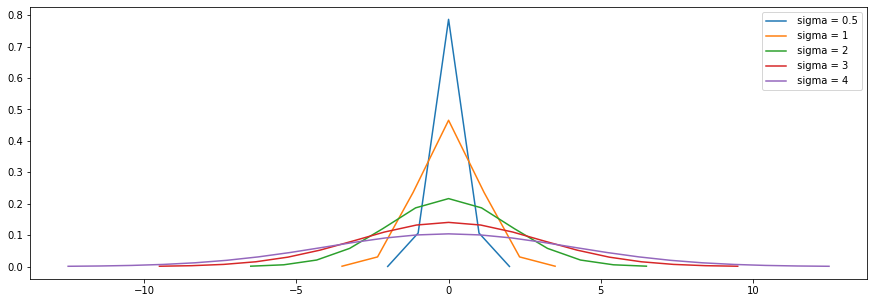

In [22]:
plt.figure(figsize=(15,5))
for sigma in [0.5, 1, 2, 3, 4]:
	g, x = gaussian(sigma, math.ceil(sigma*3)*2 + 1)
	plt.plot(x, g,  label=f" sigma = {sigma}")

plt.legend()

__*Question:*__ The figure below shows two kernels (a) and (b) as well as signal (c).
Sketch (do not focus on exact proportions of your drawing but rather on the understanding of what you are doing) the resulting convolved signal of the given input
signal and each kernel. You can optionally also implement a convolution demo based
on the signals and your convolution code, but the important part here is your understanding of the general idea of convolution.

<img src="konvolucija2.png" width="1000">

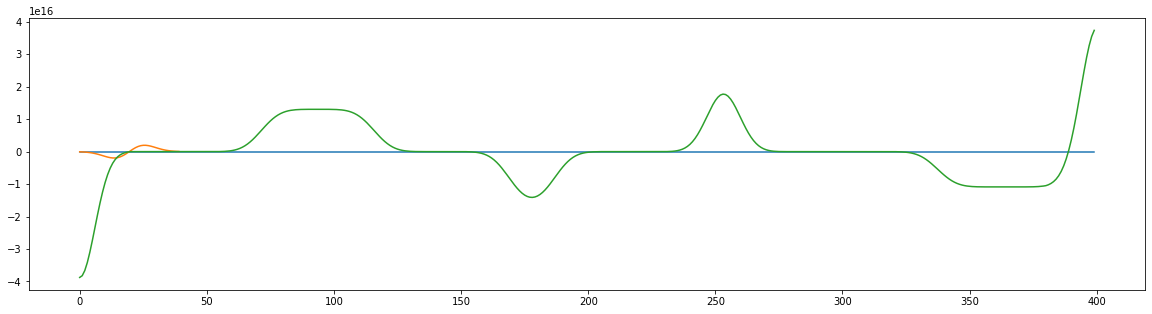

In [23]:
f = interpolate.interp1d([0,8,13,19,21,28,29,38,44,45], [2,2,0,0,1,1,0,0,2,2], kind='linear')(np.linspace(0,45,400))
k, _ = gaussian_d(2, 40)
result = simple_convolution2(f, k)
plt.figure(figsize=(20,5))
plt.plot(f)
plt.plot(k)
plt.plot(result)

## e) associativity of operations

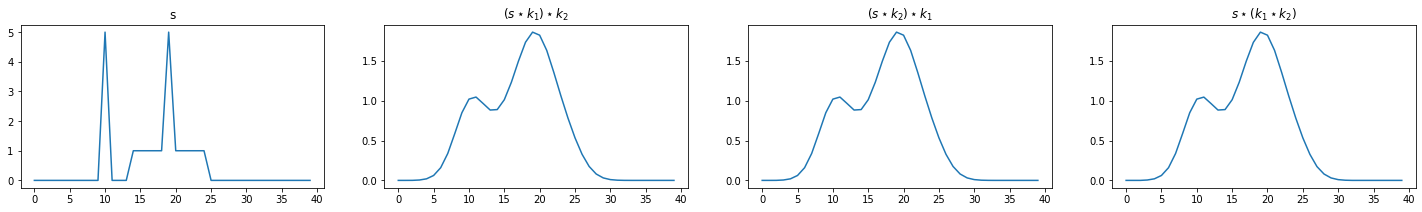

In [24]:
signal = a2_utils.read_data('signal.txt')
k1, _ = gaussian(2, 15)
k2 = np.array([0.1, 0.6, 0.4])

s_k1_k2 = simple_convolution2(simple_convolution2(signal, k1), k2)
s_k2_k1 = simple_convolution2(simple_convolution2(signal, k1), k2)
s_k1_k2_with_brackets = simple_convolution2(signal, simple_convolution2(k1, k2))

fig = plt.figure(figsize=(25,3))
ax = fig.add_subplot(1,4,1, title="s")
ax.plot(signal)
ax = fig.add_subplot(1,4,2, title="$(s\star k_1)\star k_2 $")
ax.plot(s_k1_k2)
ax = fig.add_subplot(1,4,3, title="$(s\star k_2)\star k_1 $")
ax.plot(s_k2_k1)
ax = fig.add_subplot(1,4,4, title="$s\star (k_1\star k_2) $")
ax.plot(s_k1_k2_with_brackets)

# Exercise 3: Image filtering

## A Gaussian filter in 2-D space

In [25]:
np.array([1,2,3,4]).reshape((1, -1))

array([[1, 2, 3, 4]])

In [26]:
def gaussfilter(img, sigma):
	k, _ = gaussian(sigma, math.ceil(3*sigma)*2+1)
	k = k.reshape((1,-1))
	return cv2.filter2D(cv2.filter2D(img, -1, k), -1, k.T)

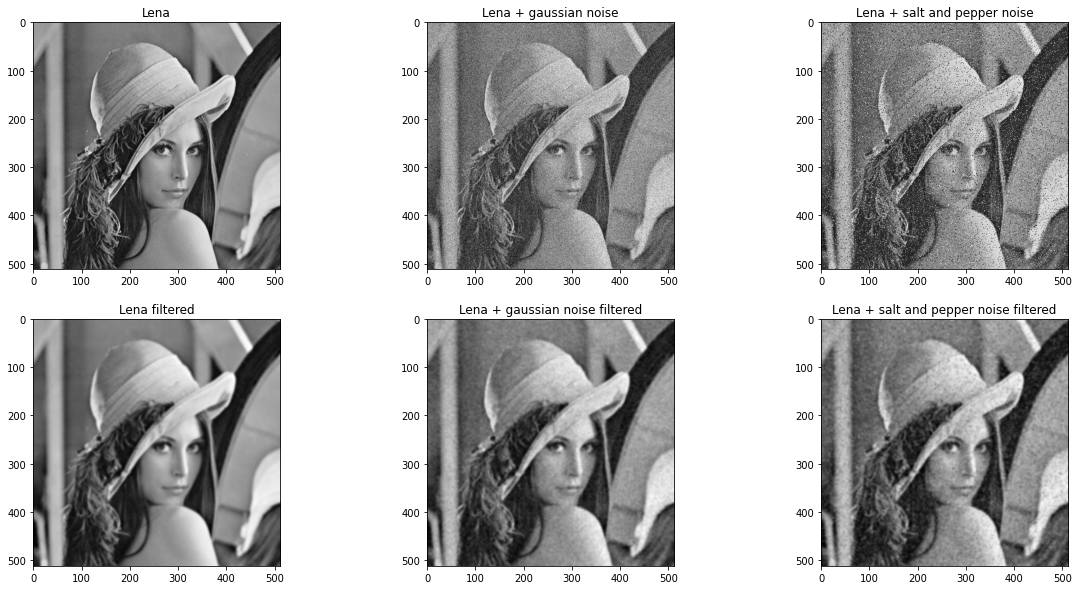

In [27]:
lena = cv2.cvtColor(cv2.imread('images/lena.png'), cv2.COLOR_BGR2GRAY)

lena_gaussed = a2_utils.gauss_noise(lena, 100)
lena_saltypeppered = a2_utils.sp_noise(lena, 0.05)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2, 3, 1, title="Lena")
ax.imshow(lena, cmap='gray')
ax = fig.add_subplot(2, 3, 2, title="Lena + gaussian noise")
ax.imshow(lena_gaussed, cmap='gray')
ax = fig.add_subplot(2, 3, 3, title="Lena + salt and pepper noise")
ax.imshow(lena_saltypeppered, cmap='gray')
ax = fig.add_subplot(2, 3, 1+3, title="Lena filtered")
ax.imshow(gaussfilter(lena, 2), cmap='gray')
ax = fig.add_subplot(2, 3, 2+3, title="Lena + gaussian noise filtered")
ax.imshow(gaussfilter(lena_gaussed, 2), cmap='gray')
ax = fig.add_subplot(2, 3, 3+3, title="Lena + salt and pepper noise filtered")
ax.imshow(gaussfilter(lena_saltypeppered, 2), cmap='gray')

__*Question:*__ Which noise is better removed using the Gaussian filter?

> The gaussian noise

## b) Convolution for image sharpening

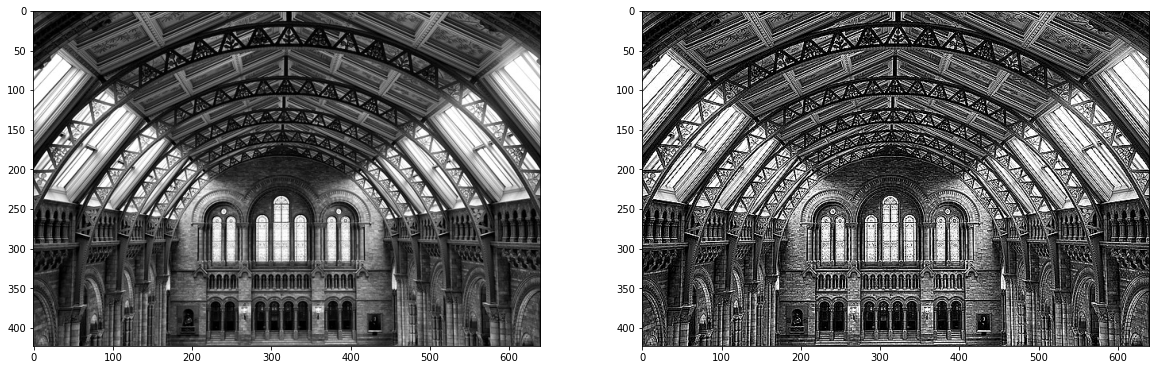

In [28]:
museum = cv2.cvtColor(cv2.imread('images/museum.jpg'), cv2.COLOR_BGR2GRAY)

k = np.array([
	[0, -1, 0],
	[-1, 5, -1],
	[0, -1, 0]
])

museum_filtered = cv2.filter2D(museum, -1, k)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(museum, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(museum_filtered, cmap='gray')

## c) Implement a nonlinear median filter

In [29]:
def simple_median(I, w):
	result = np.zeros_like(I)
	for i in range(len(I)):
		result[i] = np.median(I[max(0, i-w):min(i+w+1, len(I))])

	return result

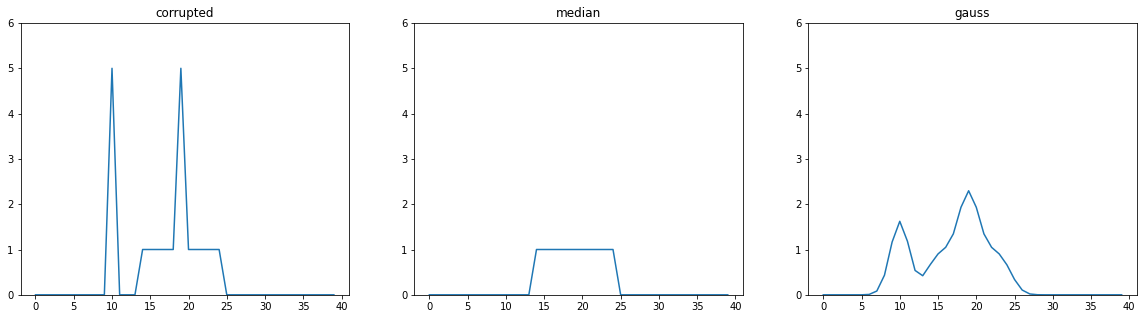

In [30]:
signal = a2_utils.read_data('signal.txt')
signal_median = simple_median(signal, 2)
k, _ = gaussian(2, 9)
signal_gaussian = simple_convolution2(signal, k)

plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.title('corrupted')
plt.ylim([0,6])
plt.plot(signal)
plt.subplot(1,3,2)
plt.title('median')
plt.ylim([0,6])
plt.plot(signal_median)
plt.subplot(1,3,3)
plt.title('gauss')
plt.ylim([0,6])
plt.plot(signal_gaussian)


__*Question:*__ Which filter performs better at this specific task? In comparison to
Gaussian filter that can be applied multiple times in any order, does the order
matter in case of median filter? What is the name of filters like this?

> Median filter performs better at this task. 
>
> Gaussian filter is commutative but median filter is not (proven by counter example below).

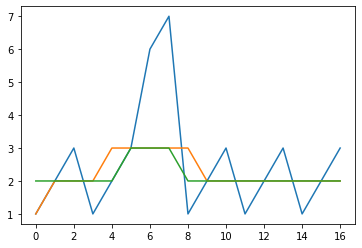

In [31]:
signal = np.array([1,2,3,1,2,3,6,7,1,2,3,1,2,3,1,2,3])
#signal = np.array(range(9))
signal_m1 = simple_median(simple_median(signal, 2),1)
signal_m2 = simple_median(simple_median(signal, 1),2)

plt.plot(signal)
plt.plot(signal_m1)
plt.plot(signal_m2)

## d) Implement a 2-D version of the median filter

In [32]:
def simple_median2(I, w):
	result = np.zeros_like(I)
	for i, v in np.ndenumerate(I):
		result[i] = np.median(I[max(0, i[0]-w):min(i[0]+w+1, I.shape[0]), max(0, i[1]-w):min(i[1]+w+1, I.shape[0])])

	return result

In [33]:
res = simple_median2(lena, 2)

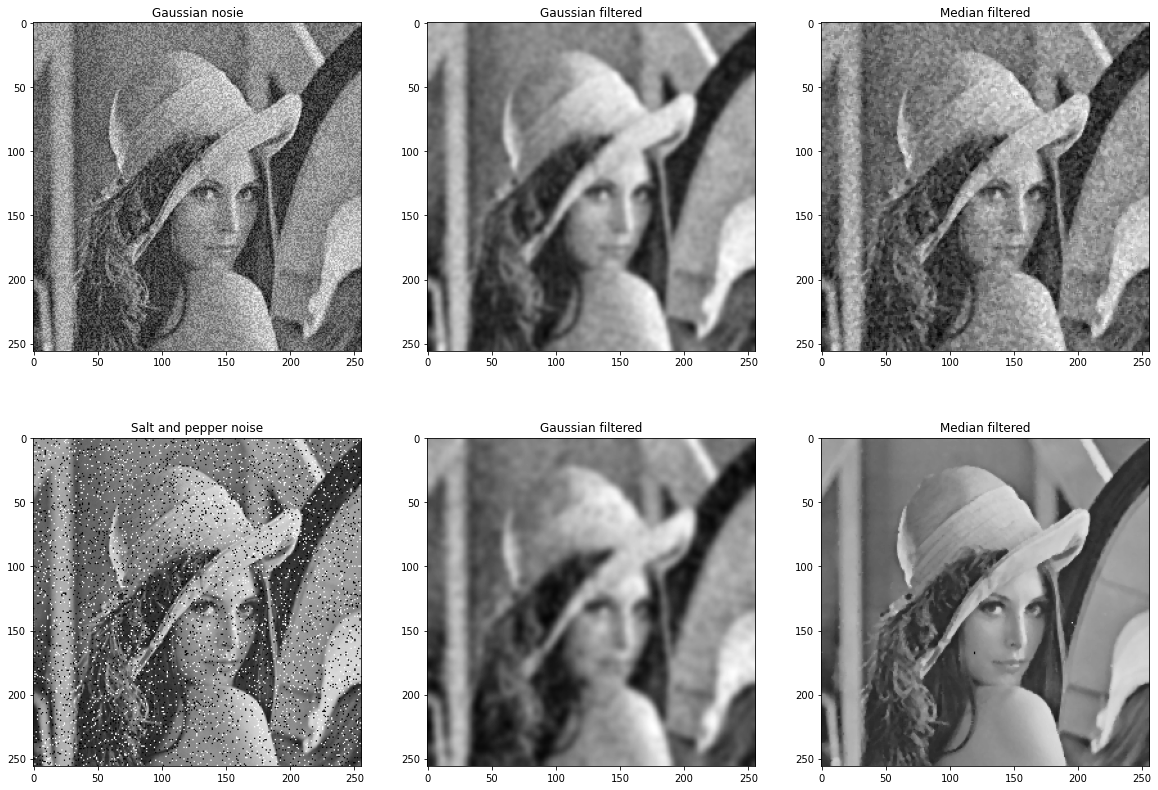

In [34]:
lena = cv2.resize(cv2.cvtColor(cv2.imread('images/lena.png'), cv2.COLOR_BGR2GRAY), (256,256))

lena_gaussed = a2_utils.gauss_noise(lena, 100)
lena_saltypeppered = a2_utils.sp_noise(lena, 0.05)

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(2, 3, 1, title="Gaussian nosie")
ax.imshow(lena_gaussed, cmap='gray')
ax = fig.add_subplot(2, 3, 2, title="Gaussian filtered")	
ax.imshow(gaussfilter(lena_gaussed, 2), cmap='gray')
ax = fig.add_subplot(2, 3, 3, title="Median filtered")
ax.imshow(simple_median2(lena_gaussed, 1), cmap='gray')

ax = fig.add_subplot(2, 3, 1+3, title="Salt and pepper noise")
ax.imshow(lena_saltypeppered, cmap='gray')
ax = fig.add_subplot(2, 3, 2+3, title="Gaussian filtered")
ax.imshow(gaussfilter(gaussfilter(lena_saltypeppered, 2), 2), cmap='gray')
ax = fig.add_subplot(2, 3, 3+3, title="Median filtered")
ax.imshow(simple_median2(lena_saltypeppered, 1), cmap='gray')

__*Question:*__ What is the computational complexity of the Gaussian filter operation?
How about the median filter? What does it depend on? Describe the computational
complexity using the $O(·)$ notation (you can assume $n \log n$ complexity for sorting).

> __Gaussian filter:__ $O(wn^2)$ where $n$ is width and hight of the image and $w$ is sidth and height of the kernel \
> __Median filter:__ $O(n^2\cdot w^2 \log w^2)$ where $n$ is width and hight of the image and $w$ is sidth and height of the kernel


## e)  Implement the hybrid image approach

In [35]:
def laplacian(sigma, size):
	l = np.zeros(size)
	l[size//2] = 1
	g, x = gaussian(sigma, size)
	g /= g.sum() - g[size//2]
	l = l-g
	return l, x
	

In [36]:
sigma = 10
laplacian_kernel, _ = laplacian(sigma, math.ceil(3*sigma)*2+1)
gaussian_kernel, _ = gaussian(sigma, math.ceil(3*sigma)*2+1)
laplacian_kernel = laplacian_kernel.reshape(1, -1)
gaussian_kernel = gaussian_kernel.reshape(1, -1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


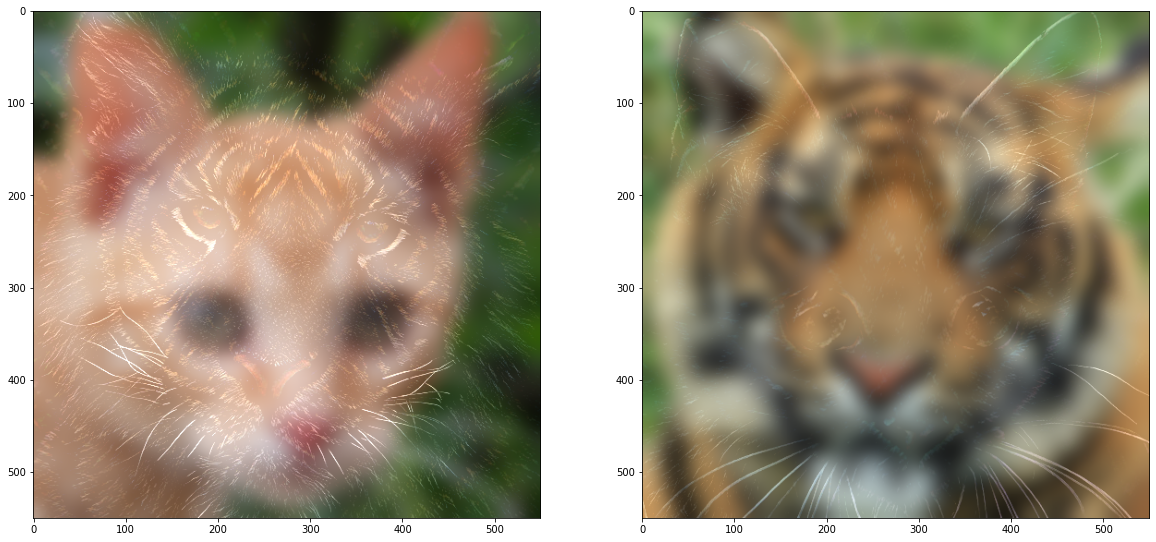

In [37]:
cat1 = cv2.cvtColor(cv2.imread('images/cat1.jpg'), cv2.COLOR_BGR2RGB)
cat2 = cv2.cvtColor(cv2.imread('images/cat2.jpg'), cv2.COLOR_BGR2RGB)

cat1_gauss = np.zeros_like(cat1)
cat1_laplace = np.zeros_like(cat1)
cat2_gauss = np.zeros_like(cat2)
cat2_laplace = np.zeros_like(cat2)

for i in range(3):
	cat1_laplace[:,:,i] = cv2.filter2D(cv2.filter2D(cat1[:,:,i], -1, laplacian_kernel), -1, laplacian_kernel.T)
	cat2_laplace[:,:,i] = cv2.filter2D(cv2.filter2D(cat2[:,:,i], -1, laplacian_kernel), -1, laplacian_kernel.T)

	cat1_gauss[:,:,i] = cv2.filter2D(cv2.filter2D(cat1[:,:,i], -1, gaussian_kernel), -1, gaussian_kernel.T)
	cat2_gauss[:,:,i] = cv2.filter2D(cv2.filter2D(cat2[:,:,i], -1, gaussian_kernel), -1, gaussian_kernel.T)

combined1 = cat2_laplace.astype('uint16') + cat1_gauss.astype('uint16')
combined2 = cat1_laplace.astype('uint16') + cat2_gauss.astype('uint16')

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(combined1)
plt.subplot(1,2,2)
plt.imshow(combined2)